# From Prompts to Workflows

In this notebook, we'll see why a single LLM prompt breaks down on multi-step tasks and how LangGraph provides **structure, state, and control flow** to fix it.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

In [3]:
from langchain_openai import ChatOpenAI

# We use OpenRouter as our LLM gateway — swap models by changing the model string
llm = ChatOpenAI(
    model="anthropic/claude-sonnet-4.6",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

/Users/sinanozdemir/Teaching/Pearson/oreilly-hands-on-gpt-llm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Why single prompts break down

Let's try asking a model to do three things in one shot:
1. Write a product description for a fictional AI tool
2. Critique the description for clarity, tone, and persuasiveness
3. Rewrite an improved version based on the critique

This is a common pattern — you want a pipeline of steps, but you cram it all into one prompt.

In [4]:
# One prompt trying to do three things at once
response = llm.invoke(
    "Write a product description for a fictional AI-powered meeting assistant called 'MeetingMind'. "
    "Then critique the description for clarity, tone, and persuasiveness. "
    "Then rewrite an improved version based on the critique."
)
print(response.content)

# MeetingMind: Product Description Exercise

---

## PART 1: Initial Product Description

---

**MeetingMind — Your AI-Powered Meeting Assistant**

MeetingMind is an AI-powered meeting assistant that uses advanced artificial intelligence and machine learning algorithms to help teams optimize their meeting workflows. The platform leverages natural language processing to transcribe, summarize, and analyze meetings in real time.

MeetingMind offers a wide range of features including but not limited to automated transcription, smart summaries, action item detection, sentiment analysis, and integration with popular project management tools. The software is designed to be used by businesses of all sizes and can be deployed across multiple platforms.

Our AI algorithms are trained on millions of data points to ensure accuracy. MeetingMind helps teams save time and improve productivity. The dashboard provides users with insights and analytics that can be leveraged to make better decisions goin

Notice how the model tries to do everything in one pass. The "critique" is shallow because the model already committed to the description and doesn't want to contradict itself. The "rewrite" barely changes anything.

This *kind of* works for simple tasks, but the model has no way to:
- **Separate generation from evaluation** — it critiques its own work in the same breath
- **Actually improve** — the critique and rewrite are performative, not substantive
- **Debug** — if the final copy is bad, which step failed?

For anything beyond toy examples, we need **structure**.

## LangGraph: Graphs as a better abstraction

LangGraph models workflows as **directed graphs**:
- **Nodes** = individual processing steps (each does one focused thing)
- **Edges** = connections that pass state between steps
- **State** = a typed dictionary that carries context through the graph

Let's rebuild the same task as a 3-node graph.

## Side-by-side comparison

In [5]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class WorkflowState(TypedDict):
    product_name: str
    draft: str
    critique: str
    final_copy: str


def generate_node(state: WorkflowState) -> dict:
    """Step 1: Write an initial product description."""
    response = llm.invoke(
        f"Write a compelling product description (2-3 paragraphs) for a fictional "
        f"AI-powered tool called '{state['product_name']}'. "
        f"It's an AI meeting assistant that joins video calls, takes notes, "
        f"identifies action items, and sends follow-up summaries."
    )
    return {"draft": response.content}

# I can pick and choose the model I want for each step
critique_llm = ChatOpenAI(
    model="minimax/minimax-m2.5",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

def critique_node(state: WorkflowState) -> dict:
    """Step 2: Critically evaluate the draft — separate LLM call, fresh perspective."""
    response = critique_llm.invoke(
        f"You are a senior copywriter reviewing a junior writer's work. "
        f"Critique this product description for:\n"
        f"- **Clarity**: Is it easy to understand? Any jargon or vague claims?\n"
        f"- **Tone**: Is it professional yet engaging? Too salesy or too flat?\n"
        f"- **Persuasiveness**: Does it make you want to try the product? What's missing?\n\n"
        f"Be specific and constructive. Point to exact phrases that need improvement.\n\n"
        f"Product description:\n{state['draft']}"
    )
    return {"critique": response.content}


def refine_node(state: WorkflowState) -> dict:
    """Step 3: Rewrite the description incorporating the critique."""
    response = llm.invoke(
        f"Rewrite this product description, addressing every point in the critique below. "
        f"Keep what works, fix what doesn't.\n\n"
        f"Original draft:\n{state['draft']}\n\n"
        f"Critique:\n{state['critique']}\n\n"
        f"Rewritten description:"
    )
    return {"final_copy": response.content}


# Build the graph
graph = StateGraph(WorkflowState)
graph.add_node("generate", generate_node)
graph.add_node("critique", critique_node)
graph.add_node("refine", refine_node)

graph.add_edge(START, "generate")
graph.add_edge("generate", "critique")
graph.add_edge("critique", "refine")
graph.add_edge("refine", END)

app = graph.compile()

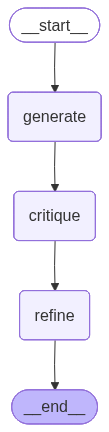

In [6]:
# Visualize the graph topology
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
# Run it
result = app.invoke({"product_name": "MeetingMind"})

print("=== Draft ===")
print(result["draft"])
print("\n=== Critique ===")
print(result["critique"])
print("\n=== Final Copy ===")
print(result["final_copy"])

=== Draft ===
# MeetingMind: Never Miss What Matters

Say goodbye to frantic note-taking and forgotten follow-ups. **MeetingMind** is your intelligent meeting companion that joins every video call — whether on Zoom, Teams, or Google Meet — and works quietly in the background so you can do what humans do best: think, collaborate, and make decisions. Powered by advanced conversational AI, MeetingMind transcribes discussions in real time, understands context the way a seasoned colleague would, and automatically surfaces the moments that actually matter. No more scrolling through hour-long recordings trying to remember who promised what.

What truly sets MeetingMind apart is its ability to *think*, not just listen. Rather than dumping raw transcripts into your inbox, it identifies action items, assigns them to the right people by name, and flags decisions made during the call — complete with the reasoning behind them. It even detects tension points and unresolved questions, giving team lea